# Plot the input for the machine learning

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import utils.create_actionshist_keys 
import utils.actionshist_utils

In [3]:
import re
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [5]:
actionshist_path = '/eos/user/l/llayer/AIErrorLogAnalysis/spark/data/actionshistory_300719.json'
data = utils.create_actionshist_keys.load_data(actionshist_path)

In [6]:
utils.actionshist_utils.set_binary_labels(data)

In [7]:
data.head()

,task_name,errors,parameters,action,action_binary_encoded
0,/amaltaro_Run2016D-v2-DoubleMuonLowMass-07Aug1...,"{u'good_sites': {}, u'bad_sites': {u'-1': {u'T...","{u'action': u'acdc', u'sites': [u'T1_US_FNAL']...",acdc,0
1,/amaltaro_Run2016D-v2-DoubleMuonLowMass-07Aug1...,"{u'good_sites': {}, u'bad_sites': {u'-1': {u'T...","{u'action': u'acdc', u'sites': [u'T1_US_FNAL']...",acdc,0
2,/amaltaro_Run2016D-v2-DoubleMuonLowMass-07Aug1...,"{u'good_sites': {}, u'bad_sites': {u'-1': {u'T...","{u'action': u'acdc', u'sites': [u'T1_US_FNAL']...",acdc,0
3,/amaltaro_Run2018A-v1-DoubleMuon-17Sep2018_102...,"{u'good_sites': {u'85': {u'T1_UK_RAL': 1}}, u'...","{u'action': u'acdc', u'cores': u'', u'xrootd':...",acdc,0
4,/amaltaro_Run2018A-v1-DoubleMuon-17Sep2018_102...,"{u'good_sites': {u'-1': {u'T2_DE_RWTH': 1, u'T...","{u'action': u'acdc', u'cores': u'', u'sites': ...",acdc,0


## 1. Plot the rough time distribution of the workflows

In [16]:
def date(task_name):
    
    p = re.findall(r'_(\d{6})', task_name)
    date = p[0]
    date = datetime.strptime(date, '%y%m%d')
    return date

In [17]:
data['date'] = data.apply(lambda x : date(x['task_name']),axis=1)

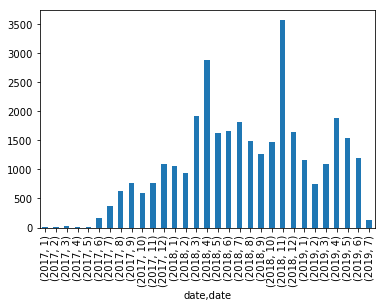

In [18]:
data['task_name'].drop_duplicates().groupby([data["date"].dt.year, 
                                               data["date"].dt.month]).count().plot(kind="bar")

## 2. Plot the ratio of acdc/non-acdc as a function of time

In [20]:
def ratio( frame ):
    
    time_series = frame['action'].groupby([frame["date"].dt.year, frame["date"].dt.month])
    
    dates = []
    counts = []
    for name, group in time_series:
        dates.append( name )
        c = group.value_counts().to_frame()
        ratio = [0,0,0,0,0]
        for i in range(len(c)):
            ratio[i] = c['action'].iloc[i]
        counts.append(ratio)
        
    counts = np.array(counts)
    non_acdc = counts[:,1:5].sum(axis=1)
    acdc = counts[:,0]
    
    ratios = []
    for i in range(len(acdc)):
        ratios.append( ( float(non_acdc[i]) / float(non_acdc[i] + acdc[i]) ) )
    x = np.linspace(0, len(ratios), len(ratios))
    
    plt.plot(x, ratios, 'o', color='red')
    plt.xticks(x, dates, rotation='vertical')
    plt.show()
    

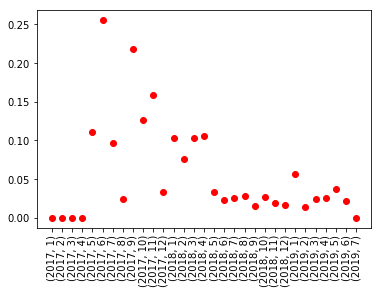

In [21]:
ratio( data )

## 3. Plot the acdc / non-acdc input distributions

In [30]:
reload(create_actionshist_keys)

<module 'create_actionshist_keys' from 'create_actionshist_keys.py'>

In [31]:
keys = create_actionshist_keys.get_keys(data, ignore_neg_code = False)

In [32]:
keys.head()

,task_name,error,site,site_state,count,label
0,/amaltaro_Run2016D-v2-DoubleMuonLowMass-07Aug1...,-1,T1_US_FNAL_Disk,bad,1,0
1,/amaltaro_Run2016D-v2-DoubleMuonLowMass-07Aug1...,-1,T3_US_FNALLPC,bad,1,0
2,/amaltaro_Run2016D-v2-DoubleMuonLowMass-07Aug1...,-1,T3_US_FNALLPC,bad,1,0
3,/amaltaro_Run2018A-v1-DoubleMuon-17Sep2018_102...,-1,T1_DE_KIT_Disk,bad,1,0
4,/amaltaro_Run2018A-v1-DoubleMuon-17Sep2018_102...,50664,T2_DE_RWTH,good,2,0


### Plot the error code distributions

In [113]:
def plot_discrimination_error(weighted = False, site_state='sum'):
    
    if site_state == 'sum':
        mask_acdc = keys['label'] == 0
        mask_nonacdc = keys['label'] == 1
    if site_state == 'good':
        mask_acdc = (keys['label'] == 0) & (keys['site_state'] == 'good')
        mask_nonacdc = (keys['label'] == 1) & (keys['site_state'] == 'good')
    if site_state == 'bad':
        mask_acdc = (keys['label'] == 0) & (keys['site_state'] == 'bad')
        mask_nonacdc = (keys['label'] == 1) & (keys['site_state'] == 'bad')
    
    if weighted == True:
        counts_acdc = keys[mask_acdc].groupby('error')['count'].sum().to_frame('counts').reset_index().rename(columns={'counts': 'counts_acdc'})
        counts_nonacdc = keys[mask_nonacdc].groupby('error')['count'].sum().to_frame('counts').reset_index().rename(columns={'counts': 'counts_nonacdc'})
        #print counts_acdc
        #labels = list(counts[key])
    else:
        counts_acdc = keys[mask_acdc]['error'].value_counts().to_frame('counts_acdc').reset_index().rename(columns={'index': 'error'})
        counts_nonacdc = keys[mask_nonacdc]['error'].value_counts().to_frame('counts_nonacdc').reset_index().rename(columns={'index': 'error'})
    join = pd.merge(counts_acdc, counts_nonacdc, on=['error'], how = 'outer')    
    join['counts_acdc_norm'] = join['counts_acdc'] /  join['counts_acdc'].sum()
    join['counts_nonacdc_norm'] = join['counts_nonacdc'] /  join['counts_nonacdc'].sum()

    labels = join.error
    
    x = np.arange(len(join))
    y_acdc = join.counts_acdc
    y_nonacdc = join.counts_nonacdc
    width = 0.4                      
    
    fig, ax = plt.subplots(figsize=(20,10))
    #rects1 = ax.bar(x, y_acdc, width, alpha=0.5, position=0)
    #rects2 = ax.bar(x, y_nonacdc, width, alpha=0.5, position=1)
    
    join.counts_acdc_norm.plot(kind='bar', color='red', ax=ax, width=width, position=1)
    join.counts_nonacdc_norm.plot(kind='bar', color='blue', ax=ax, width=width, position=0)
    
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('error_codes')
    ax.set_ylabel('Number')
    ax.set_yscale("log")
    #ax.set_xticks(x)
    #ax.set_xticklabels(labels)
    plt.xticks(x, labels, rotation='vertical')
    ax.legend()

    fig.tight_layout()
    

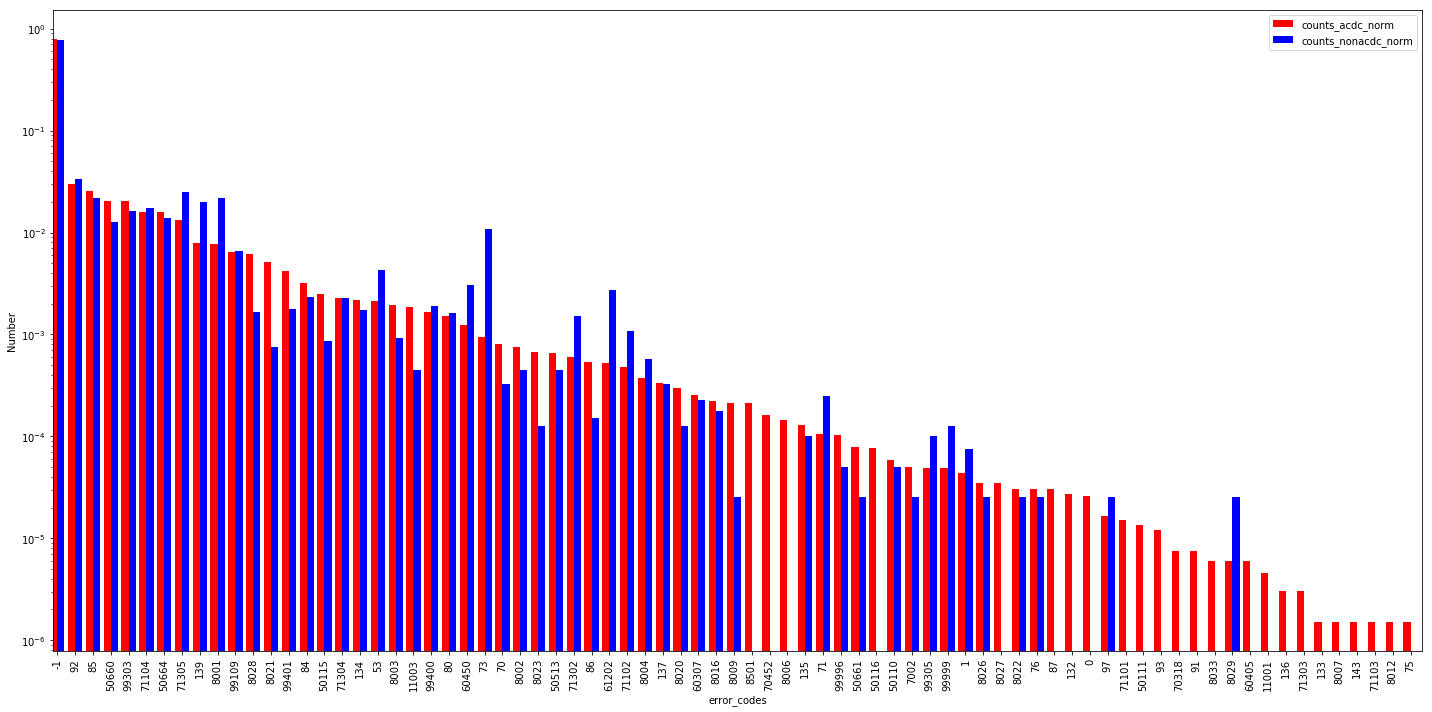

In [114]:
join = plot_discrimination_error(weighted = False)

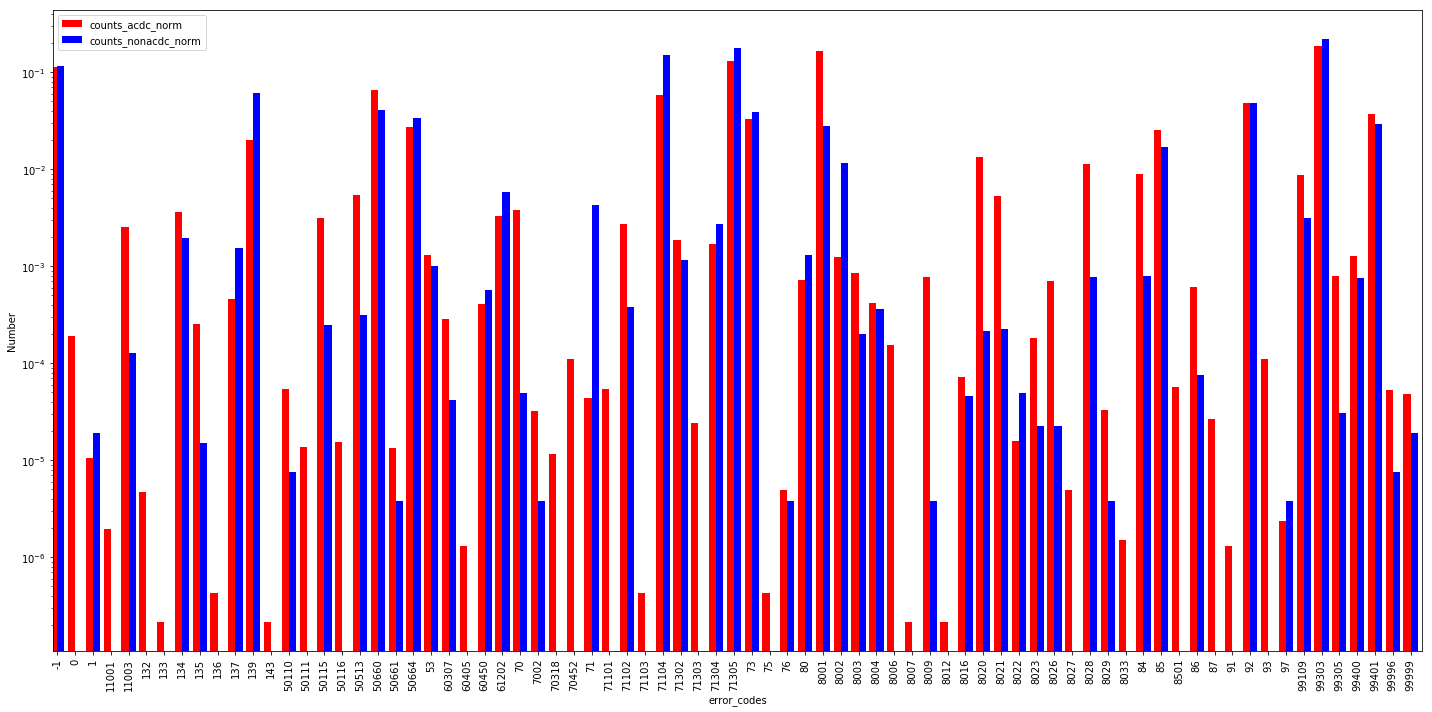

In [97]:
join = plot_discrimination_error(weighted = True)

### Plot the error message distributions